# Goal

In this version I will try to parallelize things over slices

# for andrew
As before the goal is

1. Create another .py file that can be imported
1. put all the functions here into the .py file
1. For each function add a skeleton for documentation
1. Add a main function and a command line linterface
1. Set up github and sphynx

In [1]:
import torch
torch.concatenate=torch.cat # compatibility
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from os.path import join,basename,splitext
%matplotlib widget
from scipy.interpolate import interpn
plt.set_loglevel('critical')
from scipy.misc import derivative

# Helper functions

In [2]:
def x_from_n_d(n,d):
    '''
    This function takes in an image size and pixel size, and outputs a zero centered coordinate system
    '''
    x = [torch.arange(ni)*di - (ni-1)*di/2 for ni,di in zip(n,d)]
    return x

In [3]:
def extent_from_x(x):
    '''This function gets a coordinate system and output the extent argument for matplotlib imshow'''
    d = [xi[1]-xi[0] for xi in x]
    return (x[1][0]-d[1]/2, x[1][-1]+d[1]/2, x[0][-1]+d[0]/2, x[0][0]-d[0]/2)

In [4]:
def down2ax(I,ax):
    ndims = I.ndim
    s0 = [slice(None) for i in range(ndims)]
    s1 = [slice(None) for i in range(ndims)]
    n = I.shape[ax]
    nd = n//2
    
    s0[ax] = slice(0,nd*2,2)
    s1[ax] = slice(1,nd*2,2)
    Id = I[tuple(s0)]*0.5 + I[tuple(s1)]*0.5
    return Id

In [5]:
def down2(I,ax):
    for a in ax:
        I = down2ax(I,a)
    return I
        

In [6]:
# here we have a list of files, these should be an input.
# this example is the moon observed from a telescope.  
# due to the atmosphere the moon looks "wiggly" from frame to frame, and we try to straighten out the wiggles

In [7]:
filesmoon=['frame_1_delay-0.2s[1].png','frame_0_delay-0.2s[1].png','frame_0_delay-0.2s[1].png','frame_1_delay-0.2s[1].png','frame_2_delay-0.2s[1].png','frame_3_delay-0.2s[1].png','frame_4_delay-0.2s[1].png','frame_5_delay-0.2s[1].png','frame_6_delay-0.2s[1].png','frame_7_delay-0.2s[1].png','frame_7_delay-0.2s[1].png','frame_6_delay-0.2s[1].png']

# Get some files

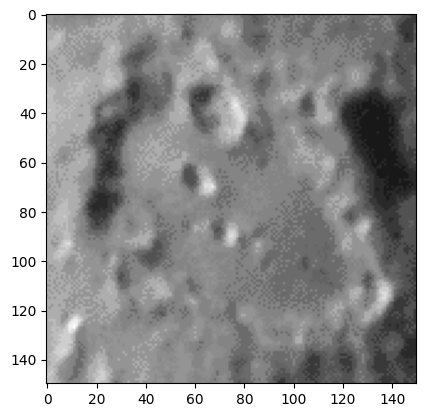

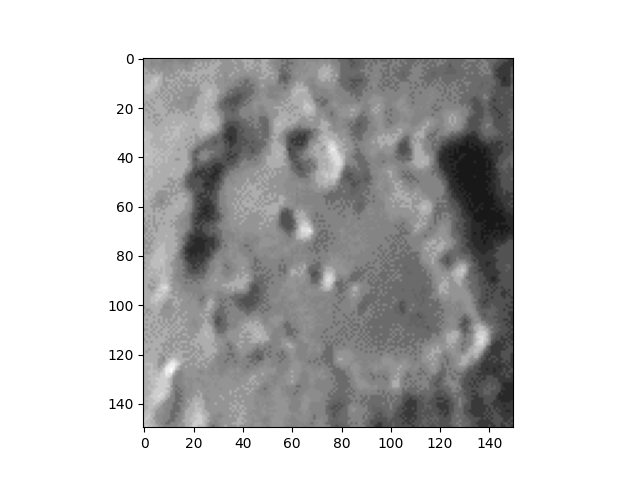

In [8]:
# something weird here to load the files
# andrew, try to make it less weird

Nfiles=12
#root = '/home/dtward/mounts/bmaproot/nafs/dtward/mitra_data/787_nissl_good_png/'
#root = '/nafs/dtward/mitra_data/787_nissl_good_png/'
#root = '/Users/12032/Downloads/mouse brain slice data'
#files = glob(join(root,'*.png'))
def key(f):
    return int( splitext(basename(f))[0].split('_')[-1] )
#files.sort(key=key)
n = len(filesmoon)
files = filesmoon[n//2-Nfiles//2 : n//2-Nfiles//2 + Nfiles]

#fig,ax = plt.subplots(1,2)
fig,ax = plt.subplots()
hfig = display(fig,display_id=True)
J_ = []
W_ = []

for i in range(Nfiles):
    Ji = plt.imread(files[i])
    
    if Ji.dtype == np.uint8:
        Ji = Ji / 255.0
    if Ji.shape[-1] == 4:
        Ji = Ji[...,:3]
    
    # find any rows or colums that are all ones
    if Ji.ndim == 2:
        Ji = Ji[...,None].repeat(3,axis=-1)
    rowones = np.all(Ji>=0.95,(0,-1))
    colones = np.all(Ji>=0.95,(1,-1))
    Wi = (1-rowones[None,:])*(1-colones[:,None])
    

    down = 1
    
    ax.cla()
    ax.imshow(Ji)
    #ax[0].cla()
    #ax[0].imshow(Ji)
    #ax[1].cla()
    #ax[1].imshow(Wi)
    hfig.update(fig)
    J_.append(Ji)
    W_.append(Wi)


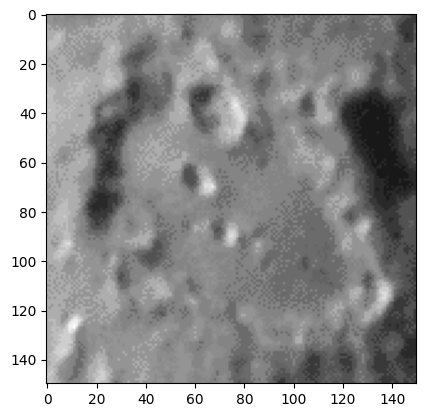

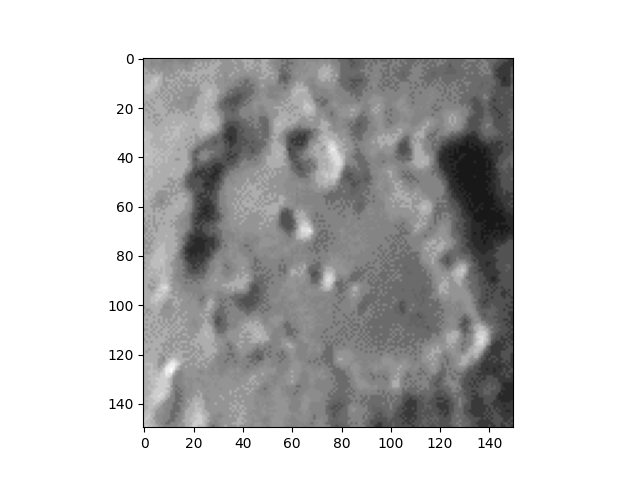

In [9]:
# next, every image is interpolated onto a grid of the same size
nJ = [Ji.shape for Ji in J_]
nJ = np.max(nJ,0)
nJ = [len(J_),nJ[0],nJ[1]]
x2d = [np.arange(n)*down - (n-1)*down/2 for n in nJ[1:]]
X2d = np.stack(np.meshgrid(*x2d,indexing='ij'),-1)
fig,ax = plt.subplots()
hfig = display(fig,display_id=True)
J__ = []
W__ = []
for Ji,Wi in zip(J_,W_):
    x = [np.arange(n)*down - (n-1)*down/2 for n in Ji.shape[:2]]
    Ji_ = interpn(x,Ji,X2d,bounds_error=False,method='nearest')
    Wi_ = interpn(x,Wi,X2d,bounds_error=False,method='nearest')
    
    Wi_ = (1.0 - np.isnan(Ji_[...,0]))*Wi_
    Ji_[np.isnan(Ji_)] = 0
    Wi_[np.isnan(Wi_)] = 0
    J__.append(Ji_)
    W__.append(Wi_)
    ax.cla()
    ax.imshow(Ji_)
    hfig.update(fig)

# note our convention is to use 
J = np.stack(J__,0).transpose(-1,0,1,2)
W = np.stack(W__)
xJ = [np.arange(nJ[0])-(nJ[0]-1)/2,x2d[0],x2d[1]]

In [11]:
# pad
# optionally, we may pad the first and last slice.  This is related to FFT for bluring and circular correlatoins.
# this padding parameter will have to be exposed
npad = 0
J = np.pad(J,((0,0),(npad,npad),(0,0),(0,0)),mode='reflect')
W = np.pad(W,((npad,npad),(0,0),(0,0)),mode='reflect')
nJ = J.shape[1:]
xJ = [np.arange(nJ[0])-(nJ[0]-1)/2,x2d[0],x2d[1]]

# Convert to pytorch

In [12]:
device = 'cpu'
dtype = torch.float32


In [13]:
J = torch.tensor(J,dtype=dtype,device=device)
W = torch.tensor(W,dtype=dtype,device=device)
xJ = [torch.tensor(x,dtype=dtype,device=device) for x in xJ]


# Interpolation

In [14]:
def interp(x,I,phii,**kwargs):
    '''
    Interpolate a signal with specified voxel spacing, in torch.    
    
    Input data should be 3D images, with first dimension a channel.
    
    phii has xyz on LAST dimension.
    
    What if there's only one slice? 
    '''
    # first we center phii based on x
    x0 = torch.stack([xi[0] for xi in x])
    d = torch.stack([xi[-1] - xi[0] for xi in x]) # this will fail if there's only one slice
    phii = (phii - x0)/d*2-1
    
    if 'align_corners' not in kwargs:
        kwargs['align_corners'] = True
    
    phiI = torch.nn.functional.grid_sample(I[None],phii.flip(-1)[None],**kwargs)[0]
    return phiI
    
    

In [15]:
def A2DtoA3D(A):
    row = torch.concatenate( (torch.ones_like(A[:,0,0,None,None]) , torch.zeros_like(A[:,0,None])  ),-1)
    col = torch.zeros_like(A[:,:,0,None])
    
    colA = torch.concatenate([col,A],-1)
    
    return torch.concatenate([row,colA],-2)

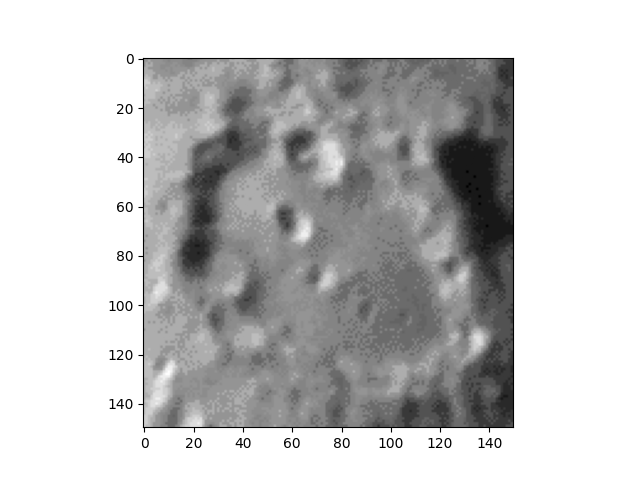

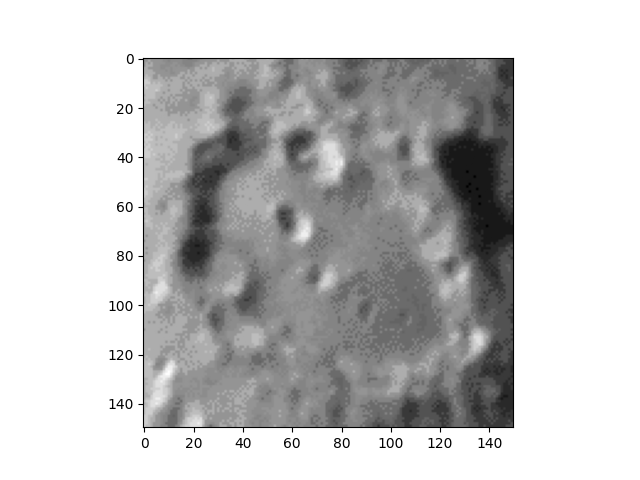

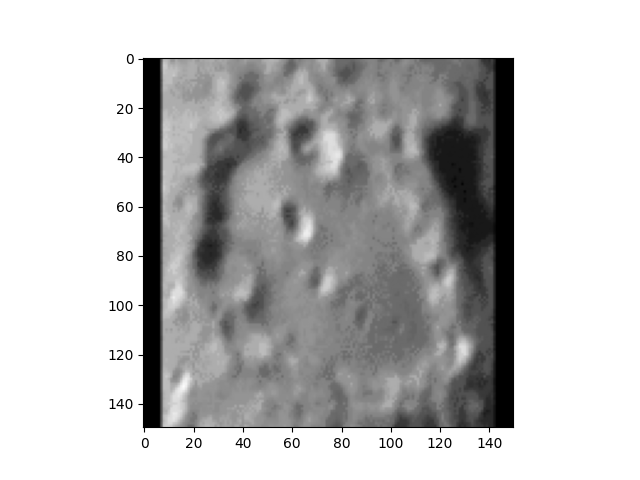

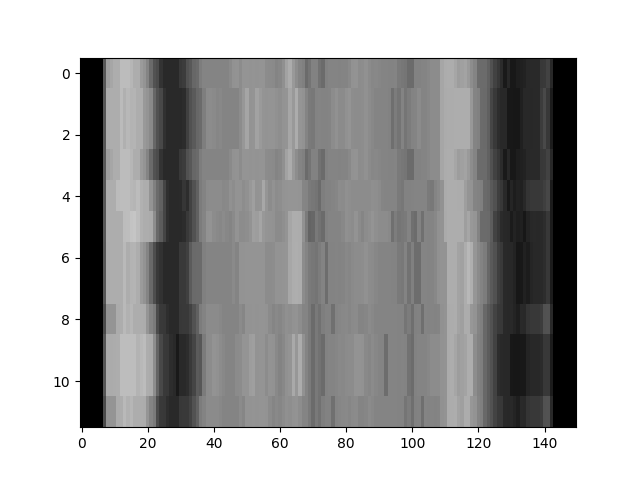

In [16]:
# to apply a linear transform I need a sequence of 2D affine matrices
XJ = torch.stack(torch.meshgrid(xJ,indexing='ij'),-1)
A = torch.eye(3)
A[0,0] = 1.1
A[1,1] = 0.9
A = A[None].repeat(nJ[0],1,1)
A = A2DtoA3D(A)
Ai = torch.linalg.inv(A)
# another function that can be imported
def AX(Ai,XJ):    
    Xs = (Ai[:,None,None,:3,:3]@XJ[...,None])[...,0] + Ai[:,None,None,:3,-1]
    return Xs
Xs = AX(Ai,XJ)
# first test identity
AJ = interp(xJ,J,XJ)
fig,ax = plt.subplots()
ax.imshow(J[:,AJ.shape[1]//2].permute(1,2,0))
fig,ax = plt.subplots()
ax.imshow(AJ[:,AJ.shape[1]//2].permute(1,2,0))
AJ = interp(xJ,J,Xs)
fig,ax = plt.subplots()
ax.imshow(AJ[:,AJ.shape[1]//2].permute(1,2,0))
fig,ax = plt.subplots()
ax.imshow(AJ[:,:,AJ.shape[2]//2].permute(1,2,0),aspect='auto')


# Group exponential

In [17]:
def exp(x,v,N=5):
    '''
    Group exponential by scaling and squaring
    v should have xyz components at the end and be 3d
    
    Take a small displacement, and compose it with itself 
    many times, to give a big displacement.
    
    If N = 1, the output is id + v
    
    If N = 2, the output is (id + v/2)\circ (id + v/2)
    
    If N = 3, the output is (id + v/8)\circ ... \circ (id + v/8)
    '''
    X = torch.stack(torch.meshgrid(*x,indexing='ij'),-1)
    phi = X.clone() + v / 2**N
    for i in range(N-1):
        # when interpolating, move xyz component to the beginning, then back
        # 0 boundary conditions are probably ok
        phi = interp(x,(phi-X).permute(-1,0,1,2),phi).permute(1,2,3,0) + phi
    
    return phi
    
    
    

In [18]:
# let's test it
# get a set of sample points for v
extendv = 1.1 # i.e. make it 10% bigger than the domain of J, to avoid wraparound
dv = down*2
vmin1 = torch.amin(xJ[1])
vmin2 = torch.amin(xJ[2])
vmax1 = torch.amax(xJ[1])
vmax2 = torch.amax(xJ[2])
vc1 = (vmin1 + vmax1)/2
vc2 = (vmin2 + vmax2)/2
vr1 = (vmax1-vmin1)/2*extendv
vr2 = (vmax2-vmin2)/2*extendv
v1 = torch.arange(vc1-vr1,vc1+vr1,dv,device=device,dtype=dtype)
v2 = torch.arange(vc2-vr2,vc2+vr2,dv,device=device,dtype=dtype)
xv = [xJ[0],v1,v2]
XV = torch.stack( torch.meshgrid(*xv,indexing='ij') , -1)
XV2d = XV[...,1:]
v2d = torch.zeros_like(XV2d) 
v2d = torch.randn(v2d.shape,dtype=v2d.dtype)


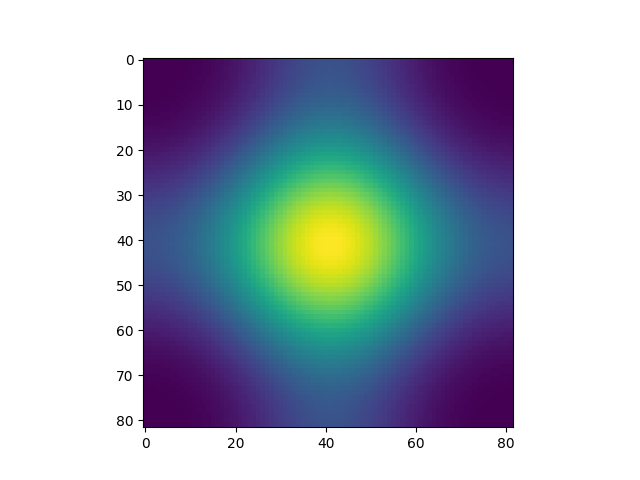

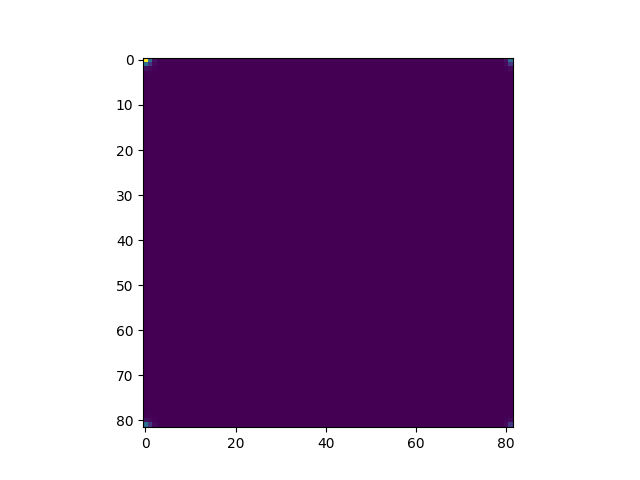

In [19]:
# get highpass and lowpass operators for 2d reg
a = 10.0
p = 2.0

def L_from_xv_a_p(xv,a,p):
    dv = xv[-1][1] - xv[-1][0]
    fv = [torch.arange(n)/n/dv for n in (len(xv[-2]), len(xv[-1]))]
    FV = torch.stack(torch.meshgrid(fv,indexing='ij'),-1)
    L = (1.0 - torch.sum(2.0*a**2*(torch.cos(2.0*np.pi*FV*dv) - 1)/dv,-1))**p
    return L
L = L_from_xv_a_p(xv,a,p)
LL = L**2
K = 1.0/LL

fig,ax = plt.subplots()
ax.imshow(L)
fig,ax = plt.subplots()
ax.imshow(K)


In [20]:
v2d = torch.fft.ifftn( torch.fft.fftn(v2d,dim=(1,2))*K[...,None] , dim=(1,2),).real


In [21]:
# need to convert v2d to v3d
def v2DToV3D(v2d):
    return torch.concatenate( ( torch.zeros_like(v2d[...,0,None]), v2d ) , -1)
v3d = v2DToV3D(v2d)    


In [22]:
v3d /= torch.std(v3d)
v3d *= 20

In [23]:
v = v2d # for later

Text(0.5, 1.0, 'Example deformation')

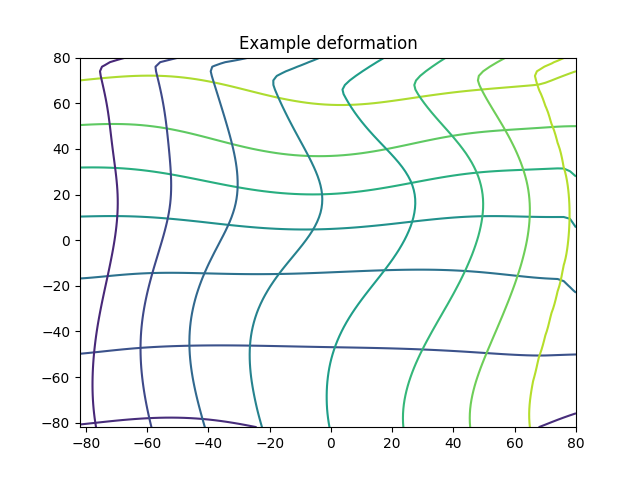

In [24]:
phi = exp(xv,v3d)
fig,ax = plt.subplots()
ax.contour(xv[2],xv[1],phi[phi.shape[0]//2,...,1])
ax.contour(xv[2],xv[1],phi[phi.shape[0]//2,...,2])
ax.set_title('Example deformation')

# Weighted SSE registration

inputs are

I,xI
J,xJ
W

v,xv 

A

a
p

ep

sigmaM
sigmaR

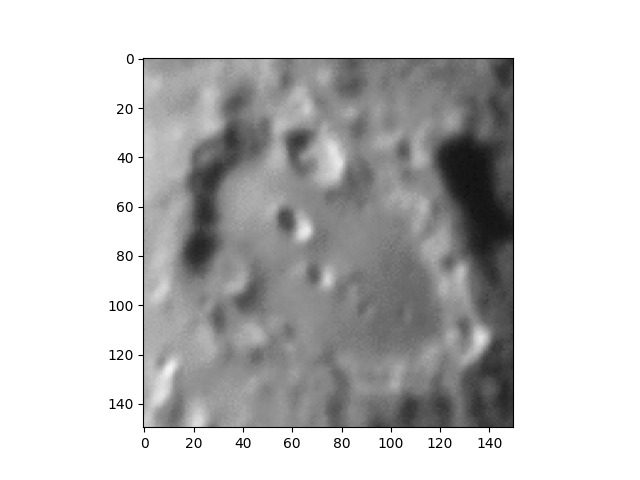

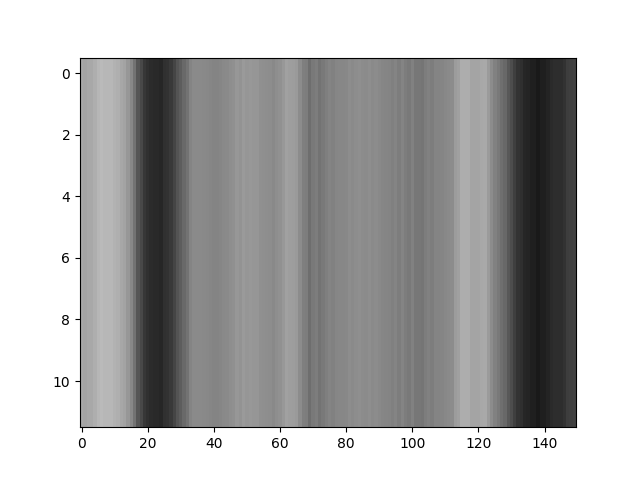

In [25]:
# initial guess
I = (torch.sum(J*W,1,keepdims=True)/(1e-6 + torch.sum(W,0,keepdims=True))).repeat(1,J.shape[1],1,1)
#I = I * W
#I = torch.mean(J,1,keepdims=True)
xI = [x.clone() for x in xJ]
fig,ax = plt.subplots()
ax.imshow(I[:,I.shape[1]//2].permute(1,2,0))
fig,ax = plt.subplots()
ax.imshow(I[:,:,I.shape[2]//2].permute(1,2,0),aspect='auto')

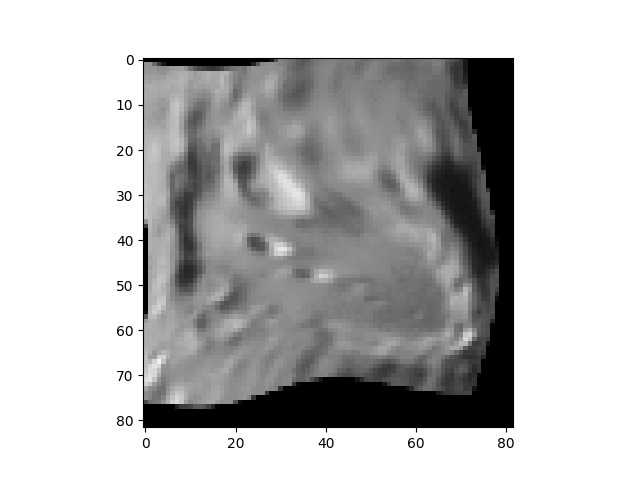

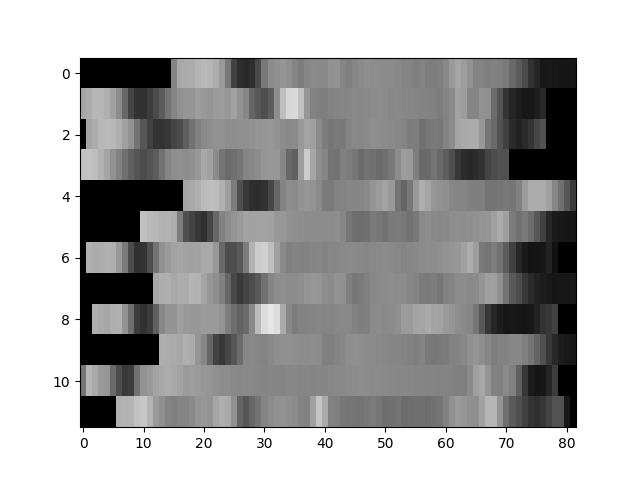

In [26]:
# transform an image with phi
phiI = interp(xI,I,phi)
fig,ax = plt.subplots()
ax.imshow(phiI[:,AJ.shape[1]//2].permute(1,2,0))



fig,ax = plt.subplots()
ax.imshow(phiI[:,:,phiI.shape[2]//2].permute(1,2,0),aspect='auto')

In [27]:
def transform_image(xI,I,xv,v,A,xJ,**kwargs):
    ''' Note this is redundant with the below, but is a nice helper function'''
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    XV = torch.stack(torch.meshgrid(*xv,indexing='ij'),-1)
    
    Ai = torch.linalg.inv(A)
    Ai = A2DtoA3D(Ai)
    Xs = AX(Ai,XJ)

    # convert v to phii
    phii = exp(xv,v2DToV3D(-v))

    # sample at Xs
    Xs = interp(xv,(phii - XV).permute(-1,0,1,2), Xs).permute(1,2,3,0) + Xs

    # transform the image
    if 'padding_mode' not in kwargs:
        kwargs['padding_mode'] = 'border'
    AphiI = interp(xI,I,Xs,**kwargs)

    return AphiI

In [28]:
def inverse_transform_image(xI,I,xv,v,A,xJ,**kwargs):
    ''' Note this is redundant with the below, but is a nice helper function'''
    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    XV = torch.stack(torch.meshgrid(*xv,indexing='ij'),-1)
    
    
    A = A2DtoA3D(A)
    

    # convert v to phii
    phi = exp(xv,v2DToV3D(v))
    
    # sample on xj
    phis = interp(xv,(phi-XV).permute(-1,0,1,2),XJ).permute(1,2,3,0) + XJ
    
    Xs = AX(A,phis)
        
    # transform the image
    if 'padding_mode' not in kwargs:
        kwargs['padding_mode'] = 'border'
    phiiAiI = interp(xI,I,Xs,**kwargs)

    return phiiAiI

In [30]:
# andrew use this one, not the commented ones below
def weighted_see_registration(xI,I,xJ,J,W,xv,v,A,a,p,sigmaM,sigmaR,niter,epT,epL,epv,draw=0,fig=None,hfig=None):

    A.requires_grad = True
    v.requires_grad = True

    XJ = torch.stack(torch.meshgrid(*xJ,indexing='ij'),-1)
    XV = torch.stack(torch.meshgrid(*xv,indexing='ij'),-1)
    dv = torch.stack([x[1] - x[0] for x in xv])
    Dv = torch.prod(dv)
    dJ = torch.stack([x[1] - x[0] for x in xJ])
    DJ = torch.prod(dJ)
    L = L_from_xv_a_p(xv,a,p)
    LL = L**2
    K = 1.0/LL

    Esave = []
    Tsave = []
    Lsave = []
    maxvsave = []
    if draw:
        if fig is None:
            fig,ax = plt.subplots(2,3)
            ax = ax.ravel()
        else:
            fig.clf()
            ax = []
            for i in range(2):
                for j in range(3):
                    ax.append(fig.add_subplot(2,3,i*3+j+1))
        if hfig is None:
            hfig = display(fig,display_id=True)
    for it in range(niter):
        if v.grad is not None:
            v.grad.zero_()
        if A.grad is not None:
            A.grad.zero_()
        # act on XJ
        Ai = torch.linalg.inv(A)
        Ai = A2DtoA3D(Ai)
        Xs = AX(Ai,XJ)

        # convert v to phii
        phii = exp(xv,v2DToV3D(-v))

        # sample at Xs
        Xs = interp(xv,(phii - XV).permute(-1,0,1,2), Xs).permute(1,2,3,0) + Xs

        # transform the image
        AphiI = interp(xI,I,Xs,padding_mode='border') # border boundary condition is important when we have a white background

        # get error
        EM = torch.sum((AphiI - J)**2*W)*DJ/sigmaM**2/2.0
        ER = torch.sum(torch.sum( torch.abs( torch.fft.fftn(v,dim=(1,2)) )**2 , -1)*LL)/sigmaR**2/2.0/v[0,...,0].numel()*Dv
        E = EM + ER
        Esave.append([E.item(),EM.item(),ER.item()])
        Tsave.append(    A[:,:2,-1].clone().detach().cpu().ravel().numpy()  )
        Lsave.append( A[:,:2,:2].clone().detach().cpu().ravel().numpy()    )
        maxvsave.append(  (torch.amax(torch.sum(v.clone().detach()**2,-1))**0.5).cpu().numpy().item()  )
        # backprop
        E.backward()

        # update
        with torch.no_grad():
            # update T
            A[:,:2,-1] -= A.grad[:,:2,-1]*epT
            # update L
            A[:,:2,:2] -= A.grad[:,:2,:2]*epL
            # rigid
            u,s,vh = torch.linalg.svd(A[:,:2,:2])
            A[:,:2,:2] = u@vh


            # update v
            v[:] = v[:] - torch.fft.ifftn(torch.fft.fftn(v.grad,dim=(1,2))*K[...,None],dim=(1,2)).real*epv

        # draw
        with torch.no_grad():
            if draw and (not it%draw or it == niter-1):
                ax[0].cla()
                ax[0].plot(Esave)
                ax[0].set_title('energy')
                ax[1].cla()
                ax[1].plot(Tsave)
                ax[1].set_title('Translation')
                ax[2].cla()
                ax[2].plot(Lsave)
                ax[2].set_title('Linear')
                ax[3].cla()
                ax[3].plot(maxvsave)
                ax[3].set_title('max |v|')
                
                
                ax[4].cla()
                ax[4].imshow(  ( (AphiI[:,:,J.shape[2]//2]-J[:,:,J.shape[2]//2])*W[:,J.shape[2]//2]  ).permute(1,2,0).cpu()*0.5+0.5  ,aspect='auto', interpolation='none')
                #ax[5].cla()
                #ax[5].imshow(  (  (AphiI[:,:,:,J.shape[3]//2]-J[:,:,:,J.shape[3]//2])*W[:,:,J.shape[3]//2] ).permute(1,2,0).cpu()*0.5+0.5  ,aspect='auto', interpolation='none')
                
                ax[5].cla()
                ax[5].imshow(  (  (AphiI[:,:,:,J.shape[3]//2]-J[:,:,:,J.shape[3]//2])*W[:,:,J.shape[3]//2] ).permute(1,2,0).cpu()*0.5+0.5  ,aspect='auto', interpolation='none')

                hfig.update(fig)

    A.requires_grad = False
    v.requires_grad = False
    
    return A,v,E.item(),ER.item()

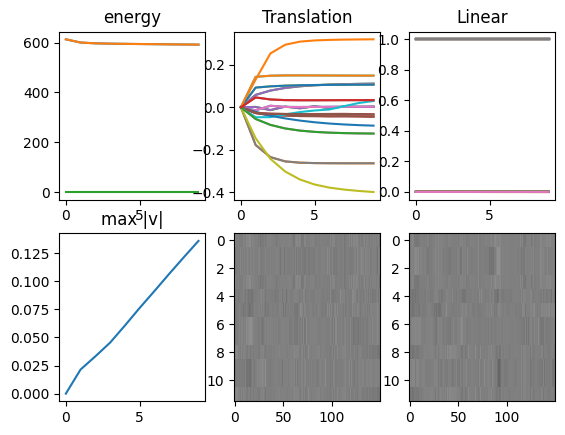

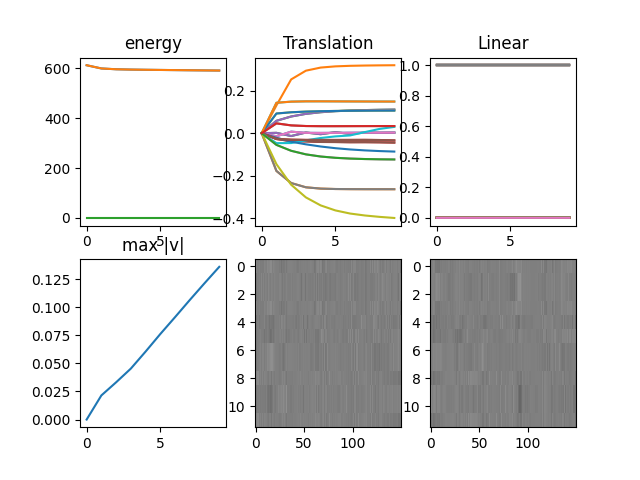

In [32]:
# this cell is just a test, it is not necessary in our code
A = torch.eye(3)[None].repeat(J.shape[1],1,1)
v = torch.zeros_like(v)

niter = 2
niter = 1
niter = 10
epT = 1e-2
epL = 1e-6
epv = 1e1
sigmaM = 1.0 # this should always be 1
sigmaR = 1e5
draw = 5


Anew,vnew,Eregistration,Ereg = weighted_see_registration(xI,I,xJ,J,W,xv,v,A,a,p,sigmaM,sigmaR,niter,epT,epL,epv,draw=5)

# Get Jacobian weights
We we want the forward transformation

In [33]:
def detjac(xv,v):
    dv = [(x[1] - x[0]).item() for x in xv]    
    detjac = torch.linalg.det( torch.stack(torch.gradient( exp(xv,v2DToV3D(v))[...,1:] , dim=(1,2),spacing=(dv[1],dv[2])),-1) )
    return detjac

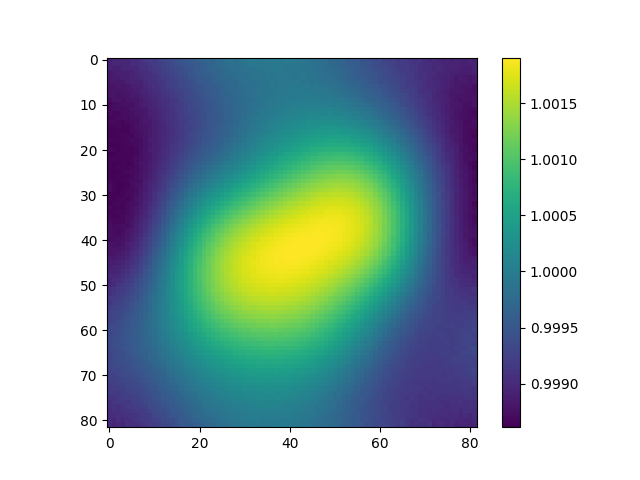

In [34]:
Wdetjac = detjac(xv,vnew)
fig,ax = plt.subplots()
mappable = ax.imshow(Wdetjac[Wdetjac.shape[0]//2])
plt.colorbar(mappable)

# Get robustness loss and weights

In [36]:
def robust_loss(RphiI,xJ,J,W,c, return_weights=False):
    ''' we input the deformed atlas I, the target J, and the voxel coordinates of J, and the robust constant c
    note there is a W here which should be binary because we're not going to sum over all the pixels
    
    TODO
    ----
    pixel size factor will show up in the weights term also
    
    '''
    
    dxJ = torch.stack([(x[1]-x[0]) for x in xJ])
    DJ = torch.prod(dxJ)
    
    err2 =  torch.sum( (RphiI - J)**2  , 0)*W # make sure the error does not go on padding
    E = c*torch.sum(err2 / (  err2 + c )  )*DJ
    
    if not return_weights:
        return E
    else:
        W = c**2 / ( (c + err2.clone().detach())**2 )*W # make sure weight is 0
        # note: we do not include pixel size d here because it will get multiplied by d later
        # no gradient calculations here
        # note, if c is really big, this goes to 0
        # and if c is really small, this looks like c/err2**2, and so also goes to 0
        return E, W

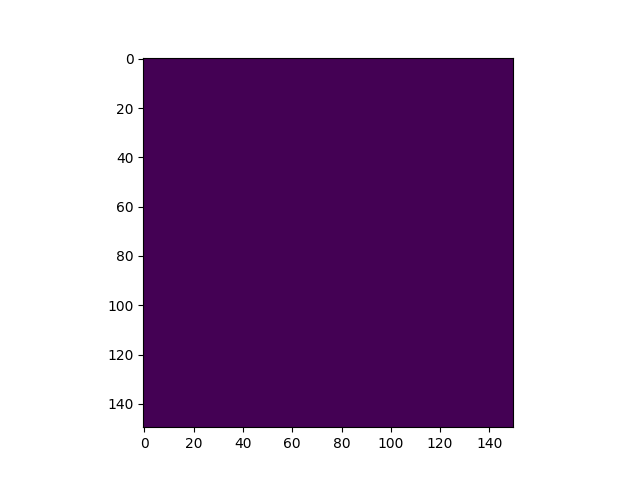

In [37]:
fig,ax = plt.subplots()
ax.imshow(W[W.shape[0]//2],interpolation='none')

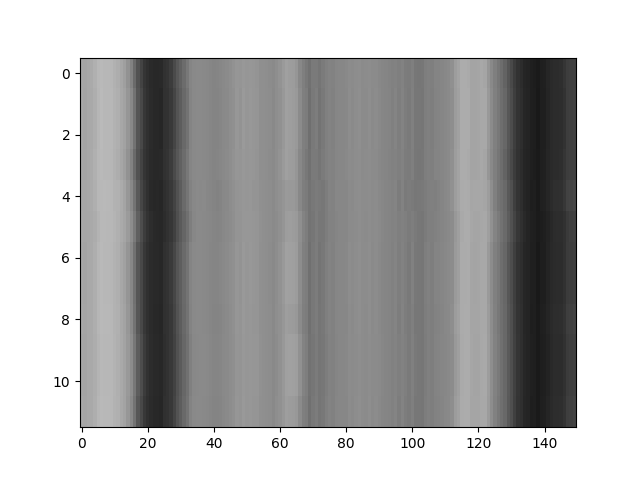

In [38]:
RphiI = transform_image(xI,I,xv,vnew,Anew,xJ)
# draw it
fig,ax = plt.subplots()
ax.imshow(RphiI[:,:,RphiI.shape[2]//2].permute(1,2,0),aspect='auto',interpolation='none')

In [39]:
c = 0.5
L,WR = robust_loss(RphiI,xJ,J,W,c, return_weights=True)

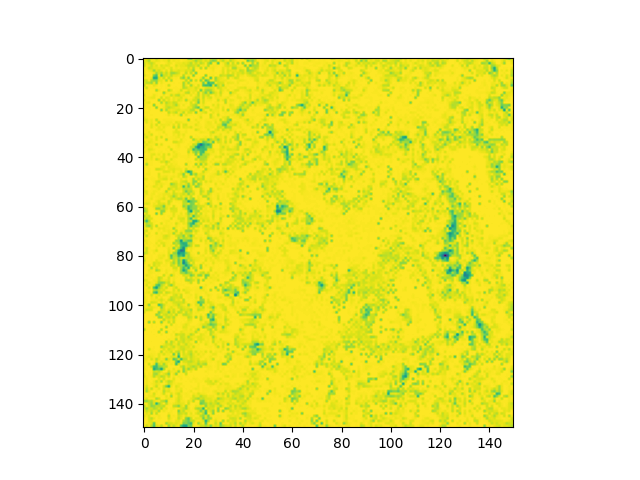

In [40]:
fig,ax = plt.subplots()
ax.imshow(WR[WR.shape[0]//2])

# Update atlas

In [41]:
def atlas_from_aligned_slices_and_weights(xI,I,phiiRiJ,W,asquare,niter=10,draw=0,fig=None,hfig=None):
    '''
    Inputs are 3D pixel locations. xI
    
    Initial guess of atlas I.
    
    We previously calculated RphiI, and we need the oppose. We need phiiRiJ
    
    a coefficient in front of laplacian.  This has units of length, so we have asquare \Delta
    
    we want to minimize
    
    note, W needs to include determinant of jacobians
    
    \int \|I - phiiRiJ\|**2 W dx + \int |L  I|**2 dx
    
    Here L will be a negative laplacian
    
    '''
    
    if draw:
        if fig is None:
            fig = plt.figure()
        if hfig is None:
            hfig = display(fig,display_id=True)
    
    # we don't want to propagate gradients here
    phiiRiJ = phiiRiJ.clone().detach()
    I = I.clone().detach()    
    W = W.clone().detach()
    
    
    
    # normalize W
    Wm = torch.max(W)
    Wn = W/Wm

     # make a Fourier domain
    n = len(xI[0])
    dI = torch.stack([x[1] - x[0] for x in xI])
    DI = torch.prod(dI)
    #d = dI[0]
    # we use the convention that slices are one unit apart
    d=1
    f = torch.arange(n,dtype=dtype,device=device)/n/d
        
  
    
    
    # define the operator in the fourier domain
    # LL plus identity
    L = (2.0*asquare* (1-torch.cos(2.0*np.pi*f*d))/d**2)
    LL = L**2
    LLnorm=LL/Wm
    oooperator = 1.0 / (1.0 + LLnorm)   
    Esave = []

            
    ERsave = []
    EMsave = []
    Esave = []
    for it in range(niter):
        # value of the loss
        ER = torch.sum( torch.fft.ifftn( torch.fft.fftn(I,dim=1)*L[...,None,None] , dim=1).real**2 )*DI
        #print('Ishape is',I.shape)
        #print('phiiRiJ shape is',phiiRiJ.shape)
        #print('W shape is',W.shape)
        #EMM = torch.sum(  (I - phiiRiJ)**2 * W )/2*DI*Wm
        #EM = torch.sum(   ((I-phiiRiJ)**2/(c + (I-phiiRiJ)**2))   )*DI # middle term of 2.12
        EM = torch.sum( (I-phiiRiJ)**2*W)*DI # daniel changed this
        E = ER + EM
        Esave.append(E.item())
        ERsave.append(ER.item())
        EMsave.append(EM.item())
        
        # update
        toblur = ( phiiRiJ*Wn + I*(1-Wn) )
        blurred = torch.fft.ifftn(torch.fft.fftn(toblur,dim=1)*oooperator[...,None,None],dim=1).real
        I = blurred
        
        if draw and (not it%draw or it == niter-1):
            fig.clf()
            ax = fig.add_subplot(2,3,1)
            ax.imshow(I[:,I.shape[1]//2].permute(1,2,0))
            ax = fig.add_subplot(2,3,2)
            ax.imshow(I[:,:,I.shape[2]//2].permute(1,2,0),interpolation='none',aspect='auto')
            ax = fig.add_subplot(2,3,3)
            ax.imshow(I[:,:,:,I.shape[3]//2].permute(1,2,0),interpolation='none',aspect='auto')
            
            ax = fig.add_subplot(2,3,4)
            ax.imshow(phiiRiJ[:,I.shape[1]//2].permute(1,2,0))
            ax = fig.add_subplot(2,3,5)
            ax.imshow(phiiRiJ[:,:,I.shape[2]//2].permute(1,2,0),interpolation='none',aspect='auto')
            ax = fig.add_subplot(2,3,6)
            ax.imshow(phiiRiJ[:,:,:,I.shape[3]//2].permute(1,2,0),interpolation='none',aspect='auto')
            hfig.update(fig)
        
    
    return I,E.item(),ER.item()

In [43]:
# andrew use this version because it does 3D blur, instead of 1d blur
# but keep the other one somewhere and give it a modified name (like underscore at the end)
def atlas_from_aligned_slices_and_weights(xI,I,phiiRiJ,W,asquare,niter=10,draw=0,fig=None,hfig=None,anisotropy_factor=4**2,return_K=False,return_fwhm=False):
    '''
    Inputs are 3D pixel locations. xI
    
    Initial guess of atlas I.
    
    We previously calculated RphiI, and we need the oppose. We need phiiRiJ
    
    a coefficient in front of laplacian.  This has units of length, so we have asquare \Delta
    
    we want to minimize
    
    note, W needs to include determinant of jacobians
    
    \int \|I - phiiRiJ\|**2 W dx + \int |L  I|**2 dx
    
    Here L will be a negative laplacian
    
    In this version we do bluring in 3D

    TODO
    ----
    
    '''
    
    if draw:
        if fig is None:
            fig = plt.figure()
        if hfig is None:
            hfig = display(fig,display_id=True)
    
    # we don't want to propagate gradients here
    phiiRiJ = phiiRiJ.clone().detach()
    I = I.clone().detach()    
    W = W.clone().detach()
    
    
    
    # normalize W
    Wm = torch.max(W)
    Wn = W/Wm

     # make a Fourier domain
    n = len(xI[0])
    dI = torch.stack([x[1] - x[0] for x in xI])
    DI = torch.prod(dI)
    #d = dI[0]
    # we use the convention that slices are one unit apart
    d=1
    #f = torch.arange(n,dtype=dtype,device=device)/n/d
    
    # try here to blur in 3D
    f = [torch.arange(ni,dtype=dtype,device=device)/ni/di for ni,di in zip(I.shape[1:],dI)]
    F = torch.stack(torch.meshgrid(*f,indexing='ij'),-1)
    
    
    # define the operator in the fourier domain
    # LL plus identity
    #L = (2.0*asquare* (1-torch.cos(2.0*np.pi*f*d))/d**2)
    asquare3d = torch.tensor([asquare,asquare*anisotropy_factor,asquare*anisotropy_factor],device=device,dtype=dtype)
    L = 2.0* torch.sum( asquare3d*(1-torch.cos(2.0*np.pi*F*dI))/dI**2,-1)
    LL = L**2
    LLnorm=LL/Wm
    oooperator = 1.0 / (1.0 + LLnorm)   
    # for FWHM computation, let's take the inverse fourier transform
    if return_fwhm or return_K:
        K = torch.fft.ifftn(oooperator).real

    Esave = []

            
    ERsave = []
    EMsave = []
    Esave = []
    for it in range(niter):
        # value of the loss
        #ER = torch.sum( torch.fft.ifftn( torch.fft.fftn(I,dim=1)*L[...,None,None] , dim=1).real**2 )*DI
        ER = torch.sum( torch.fft.ifftn( torch.fft.fftn(I,dim=(1,2,3))*L , dim=(1,2,3)).real**2 )*DI
        #print('Ishape is',I.shape)
        #print('phiiRiJ shape is',phiiRiJ.shape)
        #print('W shape is',W.shape)
        #EMM = torch.sum(  (I - phiiRiJ)**2 * W )/2*DI*Wm
        #EM = torch.sum(   ((I-phiiRiJ)**2/(c + (I-phiiRiJ)**2))   )*DI # middle term of 2.12
        EM = torch.sum( (I-phiiRiJ)**2*W)*DI # daniel changed this
        E = ER + EM
        Esave.append(E.item())
        ERsave.append(ER.item())
        EMsave.append(EM.item())
        
        # update
        toblur = ( phiiRiJ*Wn + I*(1-Wn) )
        blurred = torch.fft.ifftn(torch.fft.fftn(toblur,dim=(1,2,3))*oooperator,dim=(1,2,3)).real
        I = blurred
        
        if draw and (not it%draw or it == niter-1):
            fig.clf()
            ax = fig.add_subplot(2,3,1)
            ax.imshow(I[:,I.shape[1]//2].permute(1,2,0))
            ax = fig.add_subplot(2,3,2)
            ax.imshow(I[:,:,I.shape[2]//2].permute(1,2,0),interpolation='none',aspect='auto')
            ax = fig.add_subplot(2,3,3)
            ax.imshow(I[:,:,:,I.shape[3]//2].permute(1,2,0),interpolation='none',aspect='auto')
            
            ax = fig.add_subplot(2,3,4)
            ax.imshow(phiiRiJ[:,I.shape[1]//2].permute(1,2,0))
            ax = fig.add_subplot(2,3,5)
            ax.imshow(phiiRiJ[:,:,I.shape[2]//2].permute(1,2,0),interpolation='none',aspect='auto')
            ax = fig.add_subplot(2,3,6)
            ax.imshow(phiiRiJ[:,:,:,I.shape[3]//2].permute(1,2,0),interpolation='none',aspect='auto')
            hfig.update(fig)
        
    if return_K:
        return K
    elif return_fwhm:

        half_width_half_max = np.where(K[:,0,0].numpy()<0.5*K[0,0,0].numpy())[0][0]
        full_width_half_max_0 = 2*half_width_half_max+1
        half_width_half_max = np.where(K[0,:,0].numpy()<0.5*K[0,0,0].numpy())[0][0]
        full_width_half_max_1 = 2*half_width_half_max+1
        half_width_half_max = np.where(K[0,0,:].numpy()<0.5*K[0,0,0].numpy())[0][0]
        full_width_half_max_2 = 2*half_width_half_max+1
    
        return full_width_half_max_0,full_width_half_max_1,full_width_half_max_2
    else: # normal returns
        return I,E.item(),ER.item()
    
        

In [44]:
# get phiiRiJ
phiiRiJ = inverse_transform_image(xJ,J,xv,vnew,Anew,xI,padding_mode='border')
phiiRiW = inverse_transform_image(xJ,W[None]*WR,xv,vnew,Anew,xI,padding_mode='zeros',mode='nearest')[0]
XI = torch.stack(torch.meshgrid(xI,indexing='ij'),-1)
Wdetjacs = interp(xv,Wdetjac[None],XI)[0]

/home/dtward/.local/intelpython3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


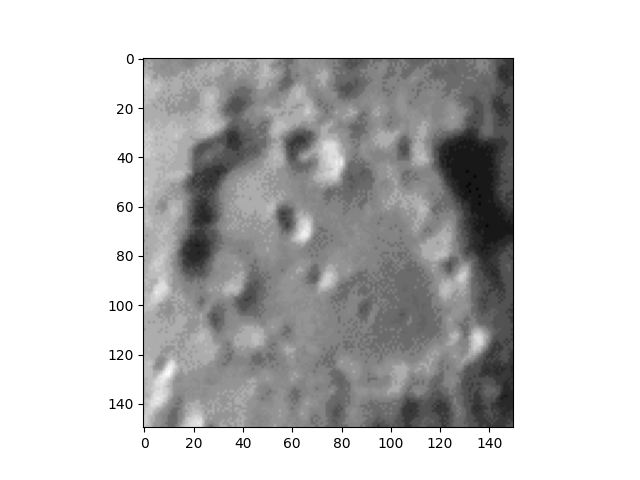

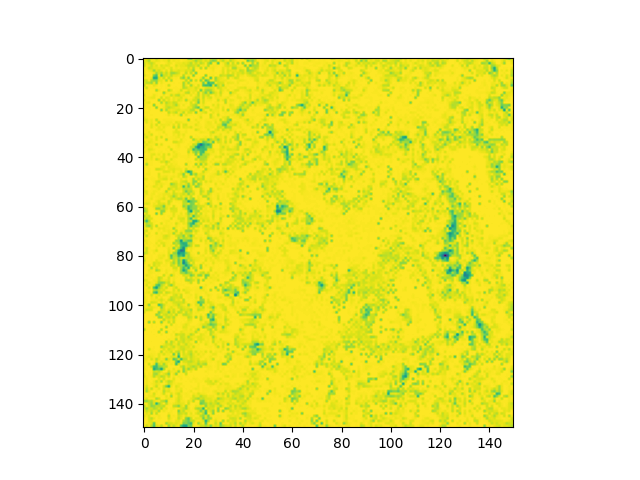

In [45]:
fig,ax = plt.subplots()
ax.imshow((phiiRiJ)[:,I.shape[1]//2].permute(1,2,0))
fig,ax = plt.subplots()
ax.imshow((phiiRiW)[I.shape[1]//2])

In [46]:
Inew = I.clone()

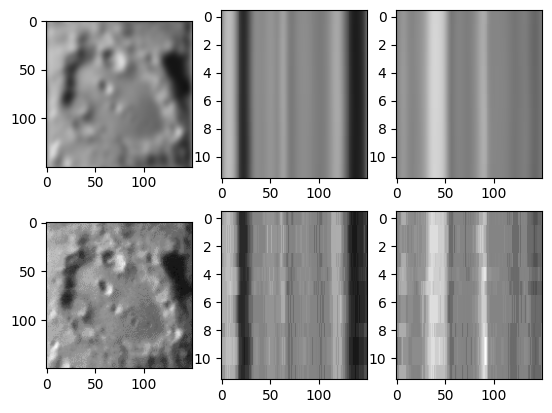

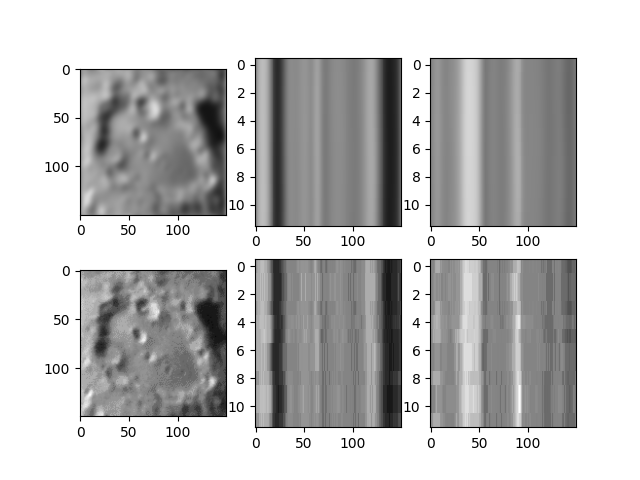

In [47]:
asquare = 2.0**2
anisotropy_factor = 1.0
Inew,Eat,ERat = atlas_from_aligned_slices_and_weights(xI,Inew*0,phiiRiJ,phiiRiW*Wdetjacs,asquare,niter=2,draw=True,anisotropy_factor=anisotropy_factor)

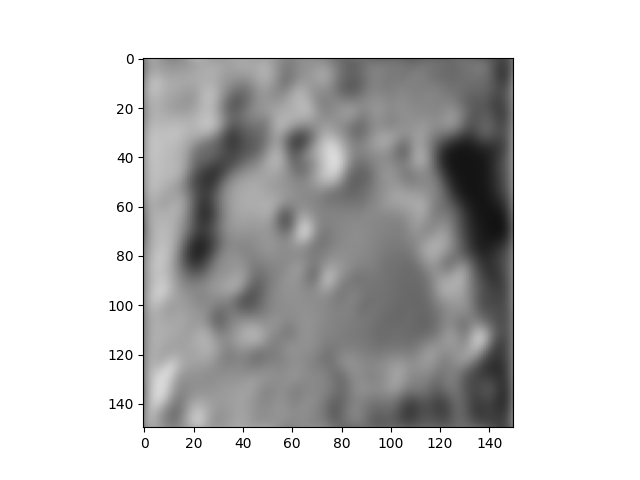

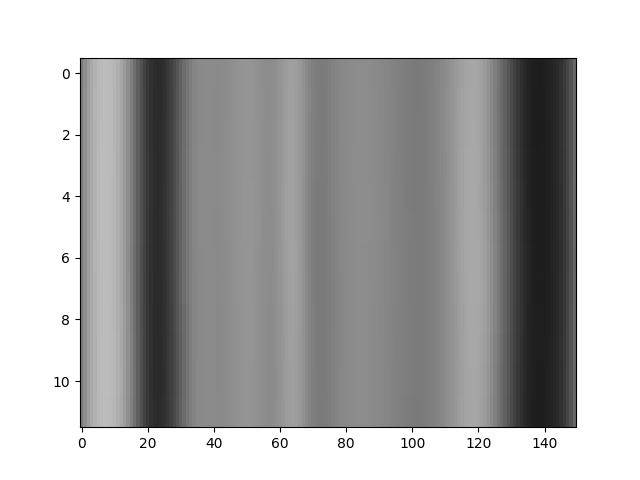

In [48]:
fig,ax = plt.subplots()
ax.imshow(Inew[:,I.shape[1]//2].permute(1,2,0))
fig,ax = plt.subplots()
ax.imshow(Inew[:,:,I.shape[2]//2].permute(1,2,0),aspect='auto')

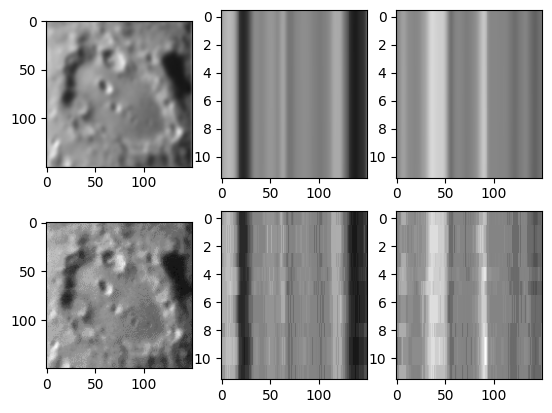

(13, 3, 3)


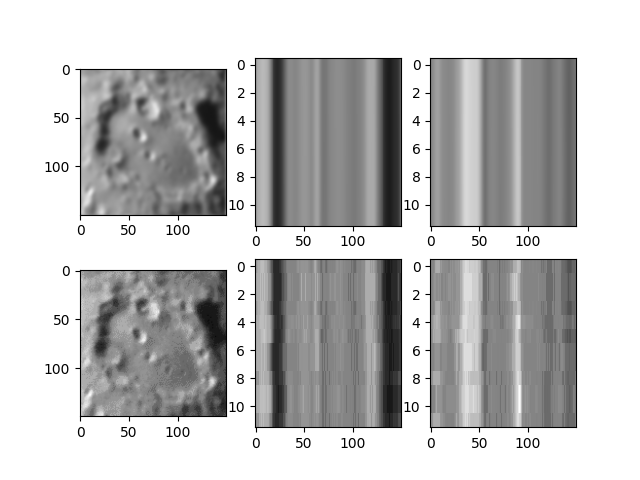

In [49]:
# let's test the FWHM
asquare = 3.5**2
anisotropy_factor = 0.3**2
fwhm = atlas_from_aligned_slices_and_weights(xI,Inew*0,phiiRiJ,phiiRiW*Wdetjacs,asquare,niter=2,draw=True,return_fwhm=True,anisotropy_factor=anisotropy_factor)
print(fwhm)


# now all the parts are in place, need to set up the big algorithm

note for andrew.  this big algorithm seems to not be wrapped in a function.  It probably should be.

In [50]:
# input parameters
# images
# xJ, J, W
# initial guess for atlas
# xI, I
# initial transforms
# xv, v
# A
# 



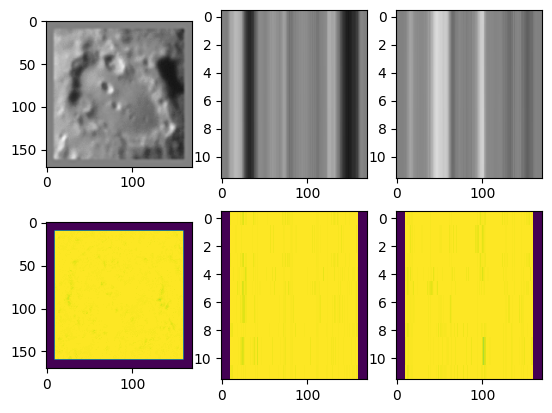

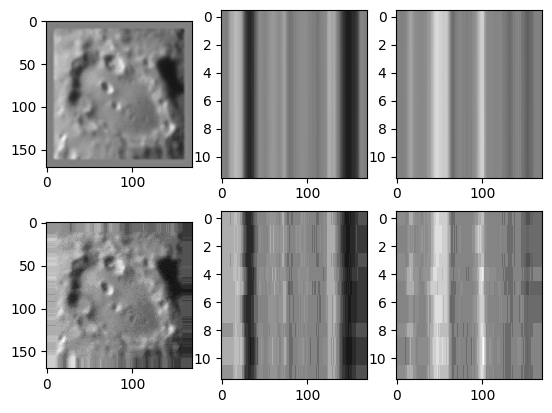

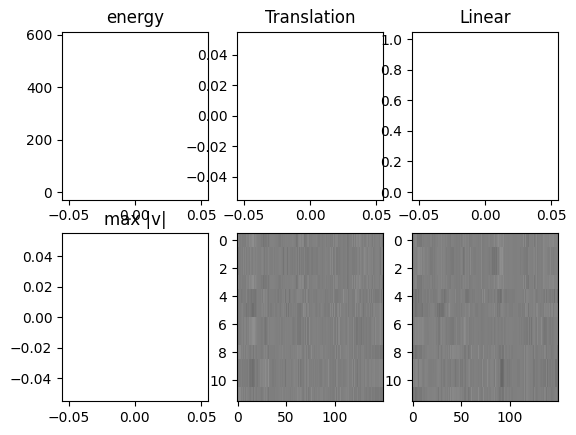

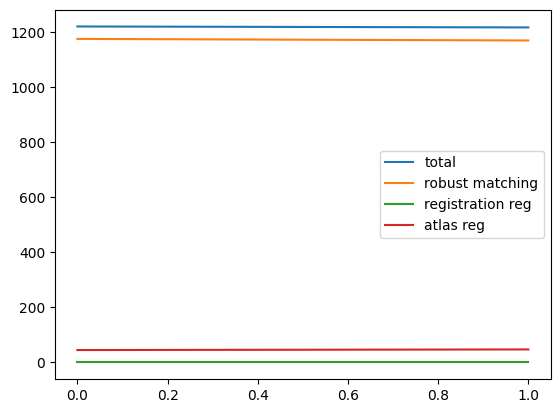

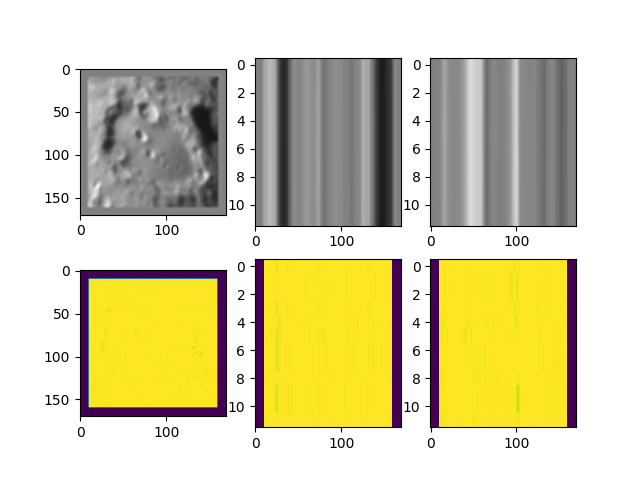

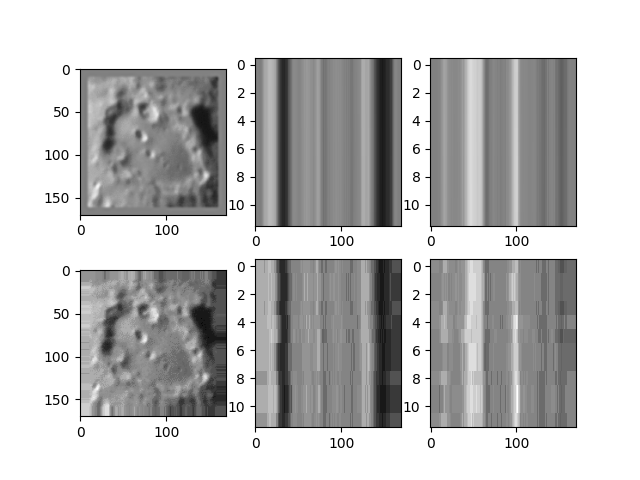

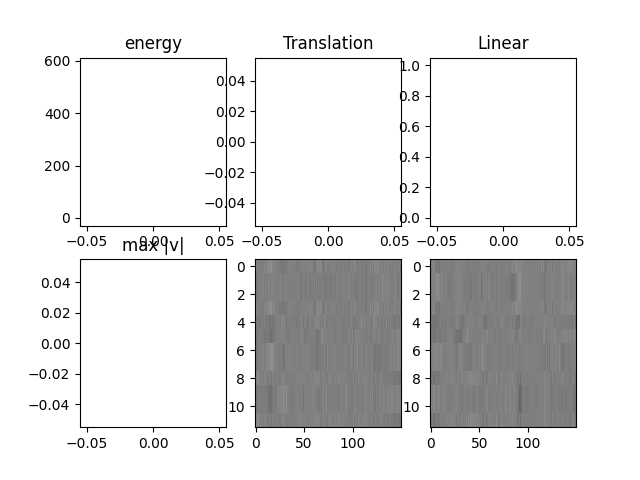

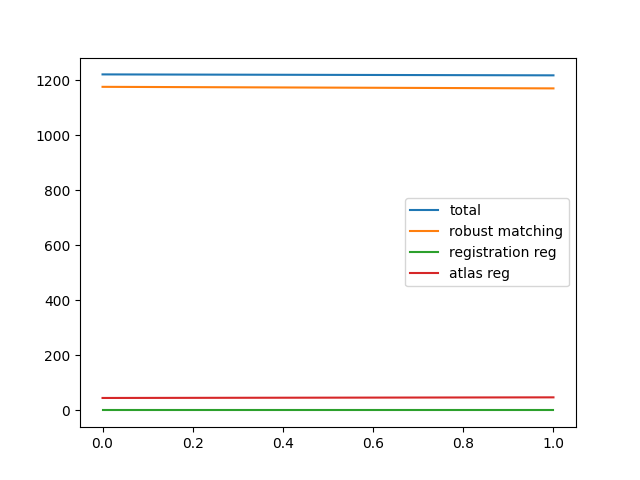

In [51]:
# in this cell I only run for one iteration with no registration
# but I do estimate the atlas
# Andrew: we don't need this cell, use the one below
niter_big_loop = 2
niter_reg = 1
niter_atlas = 50
asquare = 0.25**2
asquare0=0.25**2
asquare0 = 3.5**2
anisotropy_factor = 0.1**2

epT = 1e-2*2*2*0
epL = 1e-6*2*2*0
epv = 1e1*2
epv = 1e3
epv = 1e2*5
epv = 0
c = 1.0 # bigger c means less robustness
c = 2.0

sigmaM = 1.0 # this should always be 1
sigmaR = 1e5 # should be smaller
sigmaR = 1e4
sigmaR = 2e2
sigmaR = 5e2
a = 8.0 # was 10


fig_at,ax_at = plt.subplots(2,3)
ax_at = ax_at.ravel()
hfig_at = display(fig_at,display_id=True)

fig_at_estimate = plt.figure()
hfig_at_estimate = display(fig_at_estimate,display_id=True)
fig_reg = plt.figure()
hfig_reg = display(fig_reg,display_id=True)
fig_E,ax_E = plt.subplots(1,1)
if isinstance(ax_E,np.ndarray):
    ax_E = ax_E.ravel()
else:
    ax_E = [ax_E]
hfig_E = display(fig_E,display_id=True)
# we want xI bigger than xJ so ther are no boundary issues
bigger = 20
x2dI = [torch.arange(n+bigger,dtype=dtype)*down - (n+bigger-1)*down/2 for n in nJ[1:]]
xI = [torch.arange(nJ[0],dtype=dtype)-(nJ[0]-1)/2,x2dI[0],x2dI[1]]
XI = torch.stack(torch.meshgrid(xI,indexing='ij'),-1)

# this is the loss we want to report, not WSEE loss
Esave = []
v = torch.zeros_like(v)
A = torch.eye(3)
A = A[None].repeat(nJ[0],1,1)


# initialize with mean
I = torch.zeros((J.shape[0],XI.shape[0],XI.shape[1],XI.shape[2])) + (torch.sum(J*W,dim=(1,2,3))/torch.sum(W,dim=(0,1,2)))[...,None,None,None]    
# first get the loss and the weights, using current guesses
RphiI = transform_image(xI,I,xv,v,A,xJ)    
rloss, W_robust_loss = robust_loss(RphiI,xJ,J,W,c, return_weights=True)    

for it_big_loop in range(niter_big_loop):
    
    if it_big_loop == 0:
        asquare = 4.0**2*asquare0
    elif it_big_loop == 20:
        asquare = 2.0**2*asquare0
    elif it_big_loop == 40:
        asquare = 1.0**2*asquare0
    asquare = asquare0
    
    
    # now register, but wait until I've estimated a reasonable atlas
    if it_big_loop > 0:
        A,v,Eregistration,Ereg = weighted_see_registration(xI,I,xJ,J,W*W_robust_loss,xv,v,A,a,p,sigmaM,sigmaR,niter_reg,epT,epL,epv,draw=5,fig=fig_reg,hfig=hfig_reg)
    else:
        Ereg = 0.0
    # and we want to add Ereg to our loss
    
    # now get jacobians
    Wdetjac = detjac(xv,v)
    
    # now update atlas
    phiiRiJ = inverse_transform_image(xJ,J,xv,v,A,xI,padding_mode='border',mode='nearest')
    phiiRiW = inverse_transform_image(xJ,W[None]*W_robust_loss,xv,v,A,xI,padding_mode='zeros',mode='nearest')[0]    
    Wdetjacs = interp(xv,Wdetjac[None],XI)[0]
    I,Eat,ERat = atlas_from_aligned_slices_and_weights(xI,I,phiiRiJ,phiiRiW*Wdetjacs,asquare,niter=niter_atlas,fig=fig_at_estimate,hfig=hfig_at_estimate,draw=True,anisotropy_factor=anisotropy_factor)
    # and we want to add ERat to the loss
    
    # get the loss and the weights, using current guesses
    RphiI = transform_image(xI,I,xv,v,A,xJ)    
    rloss, W_robust_loss = robust_loss(RphiI,xJ,J,W,c, return_weights=True)    
    # this is the loss we want to report, it's the loss with the current parameters
    
    ax_at[0].cla()
    ax_at[0].imshow(I[:,I.shape[1]//2].permute(1,2,0))
    ax_at[1].cla()
    ax_at[1].imshow(I[:,:,I.shape[2]//2].permute(1,2,0),aspect='auto',interpolation='none')
    ax_at[2].cla()
    ax_at[2].imshow(I[:,:,:,I.shape[3]//2].permute(1,2,0),aspect='auto',interpolation='none')
    
    
    Wshow = (phiiRiW*Wdetjacs)
    ax_at[3].cla()
    ax_at[3].imshow(Wshow[I.shape[1]//2])
    ax_at[4].cla()
    ax_at[4].imshow(Wshow[:,I.shape[2]//2],aspect='auto',interpolation='none')
    ax_at[5].cla()
    ax_at[5].imshow(Wshow[:,:,I.shape[3]//2],aspect='auto',interpolation='none')
    
    
    # is this the right error? yes I think so
    Esave.append([rloss.item()+Ereg+ERat,rloss.item(),Ereg,ERat])
    ax_E[0].cla()
    ax_E[0].plot(Esave)
    ax_E[0].legend(['total', 'robust matching', 'registration reg', 'atlas reg'])
    
    hfig_at.update(fig_at)
    hfig_E.update(fig_E)
    
    #print(rloss.item() + Ereg + ERat)
    
    fig_at_estimate.savefig(f'atlas_{it_big_loop:06d}.png')
    
    

In [52]:
Isave = I # we had saved this for a comparison in the paper, not needed

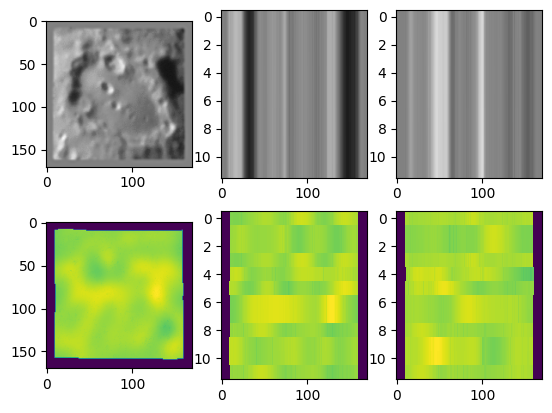

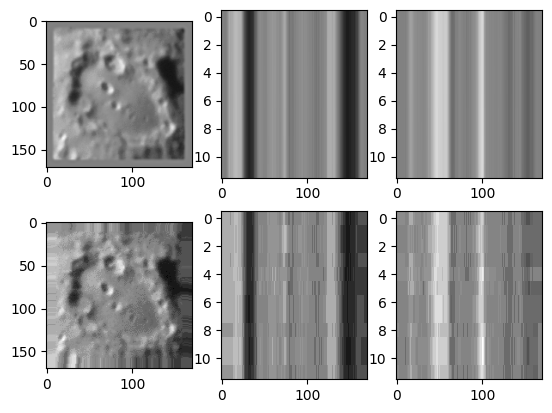

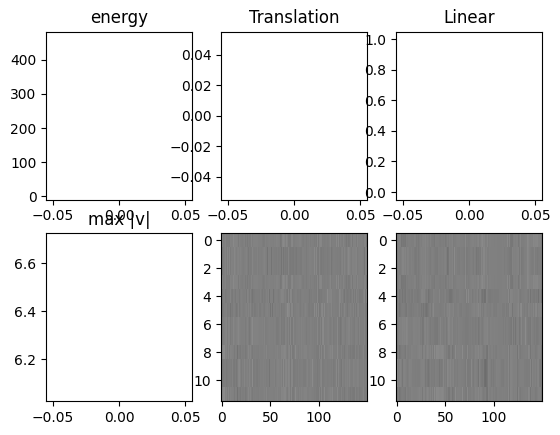

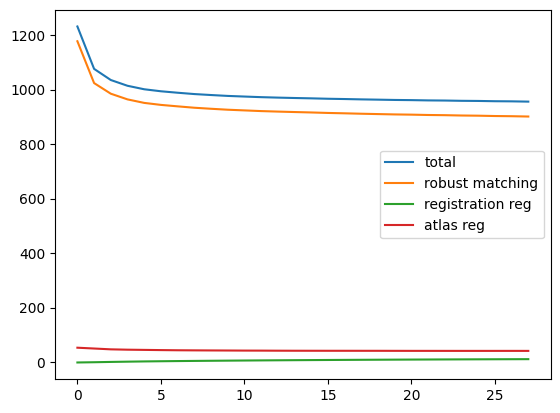

KeyboardInterrupt: 

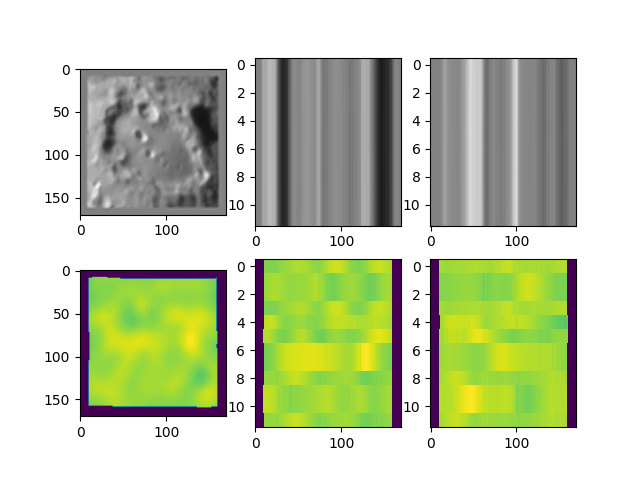

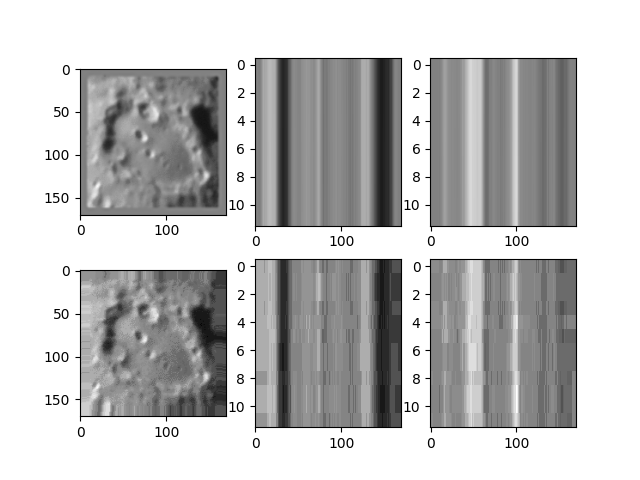

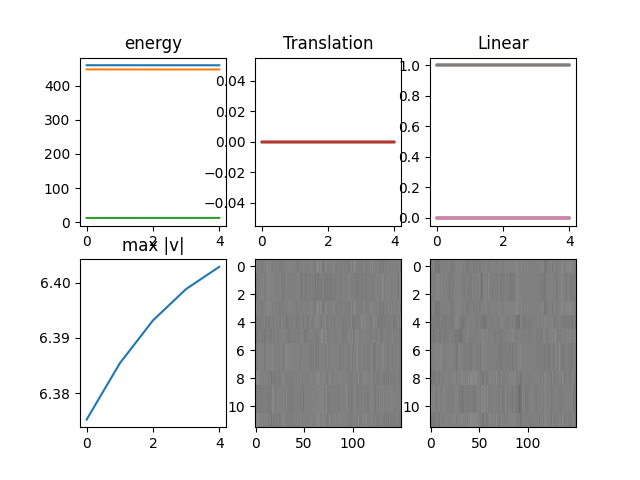

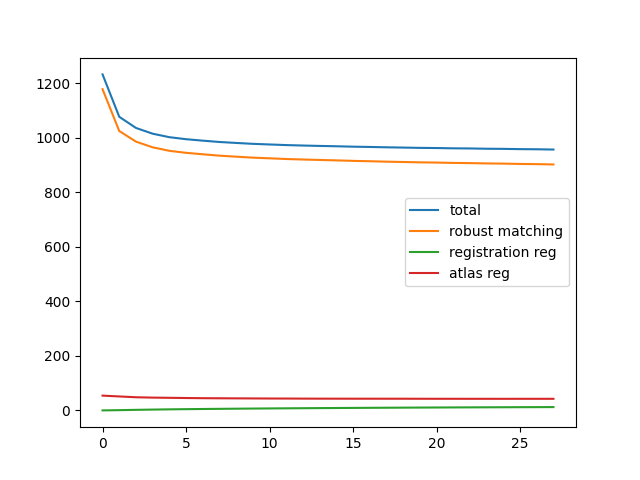

In [53]:
# this cell should be the main function
niter_big_loop = 400
niter_reg = 5
niter_atlas = 5
asquare = 0.25**2
asquare0=0.25**2
asquare0 = 3.5**2
anisotropy_factor = 0.1**2

epT = 1e-2*2*2*0
epL = 1e-6*2*2*0
epv = 1e1*2
epv = 1e3
epv = 1e2*5
c = 1.0 # bigger c means less robustness
c = 2.0

sigmaM = 1.0 # this should always be 1
sigmaR = 1e5 # should be smaller
sigmaR = 1e4
sigmaR = 2e2
sigmaR = 5e2
a = 8.0 # was 10
a = 6.0


fig_at,ax_at = plt.subplots(2,3)
ax_at = ax_at.ravel()
hfig_at = display(fig_at,display_id=True)

fig_at_estimate = plt.figure()
hfig_at_estimate = display(fig_at_estimate,display_id=True)
fig_reg = plt.figure()
hfig_reg = display(fig_reg,display_id=True)
fig_E,ax_E = plt.subplots(1,1)
if isinstance(ax_E,np.ndarray):
    ax_E = ax_E.ravel()
else:
    ax_E = [ax_E]
hfig_E = display(fig_E,display_id=True)
# we want xI bigger than xJ so ther are no boundary issues
bigger = 20
x2dI = [torch.arange(n+bigger,dtype=dtype)*down - (n+bigger-1)*down/2 for n in nJ[1:]]
xI = [torch.arange(nJ[0],dtype=dtype)-(nJ[0]-1)/2,x2dI[0],x2dI[1]]
XI = torch.stack(torch.meshgrid(xI,indexing='ij'),-1)

# this is the loss we want to report, not WSEE loss
Esave = []
v = torch.zeros_like(v)
A = torch.eye(3)
A = A[None].repeat(nJ[0],1,1)


# initialize with mean
I = torch.zeros((J.shape[0],XI.shape[0],XI.shape[1],XI.shape[2])) + (torch.sum(J*W,dim=(1,2,3))/torch.sum(W,dim=(0,1,2)))[...,None,None,None]    
# first get the loss and the weights, using current guesses
RphiI = transform_image(xI,I,xv,v,A,xJ)    
rloss, W_robust_loss = robust_loss(RphiI,xJ,J,W,c, return_weights=True)    

for it_big_loop in range(niter_big_loop):
    
    if it_big_loop == 0:
        asquare = 4.0**2*asquare0
    elif it_big_loop == 20:
        asquare = 2.0**2*asquare0
    elif it_big_loop == 40:
        asquare = 1.0**2*asquare0
    asquare = asquare0
    
    
    # now register, but wait until I've estimated a reasonable atlas
    if it_big_loop > 0:
        A,v,Eregistration,Ereg = weighted_see_registration(xI,I,xJ,J,W*W_robust_loss,xv,v,A,a,p,sigmaM,sigmaR,niter_reg,epT,epL,epv,draw=5,fig=fig_reg,hfig=hfig_reg)
    else:
        Ereg = 0.0
    # and we want to add Ereg to our loss
    
    # now get jacobians
    Wdetjac = detjac(xv,v)
    
    # now update atlas
    phiiRiJ = inverse_transform_image(xJ,J,xv,v,A,xI,padding_mode='border',mode='nearest')
    phiiRiW = inverse_transform_image(xJ,W[None]*W_robust_loss,xv,v,A,xI,padding_mode='zeros',mode='nearest')[0]    
    Wdetjacs = interp(xv,Wdetjac[None],XI)[0]
    I,Eat,ERat = atlas_from_aligned_slices_and_weights(xI,I,phiiRiJ,phiiRiW*Wdetjacs,asquare,niter=niter_atlas,fig=fig_at_estimate,hfig=hfig_at_estimate,draw=True,anisotropy_factor=anisotropy_factor)
    # and we want to add ERat to the loss
    
    # get the loss and the weights, using current guesses
    RphiI = transform_image(xI,I,xv,v,A,xJ)    
    rloss, W_robust_loss = robust_loss(RphiI,xJ,J,W,c, return_weights=True)    
    # this is the loss we want to report, it's the loss with the current parameters
    
    ax_at[0].cla()
    ax_at[0].imshow(I[:,I.shape[1]//2].permute(1,2,0))
    ax_at[1].cla()
    ax_at[1].imshow(I[:,:,I.shape[2]//2].permute(1,2,0),aspect='auto',interpolation='none')
    ax_at[2].cla()
    ax_at[2].imshow(I[:,:,:,I.shape[3]//2].permute(1,2,0),aspect='auto',interpolation='none')
    
    
    Wshow = (phiiRiW*Wdetjacs)
    ax_at[3].cla()
    ax_at[3].imshow(Wshow[I.shape[1]//2])
    ax_at[4].cla()
    ax_at[4].imshow(Wshow[:,I.shape[2]//2],aspect='auto',interpolation='none')
    ax_at[5].cla()
    ax_at[5].imshow(Wshow[:,:,I.shape[3]//2],aspect='auto',interpolation='none')
    
    
    # is this the right error? yes I think so
    Esave.append([rloss.item()+Ereg+ERat,rloss.item(),Ereg,ERat])
    ax_E[0].cla()
    ax_E[0].plot(Esave)
    ax_E[0].legend(['total', 'robust matching', 'registration reg', 'atlas reg'])
    
    hfig_at.update(fig_at)
    hfig_E.update(fig_E)
    
    #print(rloss.item() + Ereg + ERat)
    
    fig_at_estimate.savefig(f'atlas_{it_big_loop:06d}.png')
    
    

In [ ]:
# we will need to decide what the outputs are and how they are saved
# I suggest just npy or npz files for everything
# 

In [ ]:
asdf # end here

In [ ]:
phiiRiJ = inverse_transform_image(xJ,J,xv,v,A,xI,padding_mode='border',mode='bilinear')
phiiRiJ0 = inverse_transform_image(xJ,J,xv,v*0,A,xI,padding_mode='border',mode='bilinear')

phiiRiJ = inverse_transform_image(xJ,J,xv,v,A,xI,padding_mode='border',mode='nearest')
phiiRiJ0 = inverse_transform_image(xJ,J,xv,v*0,A,xI,padding_mode='border',mode='nearest')

In [ ]:
torch.max(torch.abs(phiiRiJ - phiiRiJ0))


In [ ]:
fig,ax = plt.subplots(2,2)
ax = ax.ravel()
phiiRiJ0_ = phiiRiJ0.mean((0,1))
phiiRiJ_ = phiiRiJ.mean((0,1))
ax[0].imshow(phiiRiJ0_)
ax[1].imshow(phiiRiJ_)
ax[2].plot(phiiRiJ0[0,phiiRiJ0.shape[1]//2,phiiRiJ0_.shape[0]//2],label='slice')
ax[2].plot(phiiRiJ0_[phiiRiJ0_.shape[0]//2],label='init')
ax[2].plot(phiiRiJ_[phiiRiJ_.shape[0]//2],label='final')
ax[2].legend()
ax[3].plot(phiiRiJ0[0,phiiRiJ0.shape[1]//2,:,phiiRiJ0_.shape[1]//2],label='slice')
ax[3].plot(phiiRiJ0_[:,phiiRiJ0_.shape[1]//2],label='init')
ax[3].plot(phiiRiJ_[:,phiiRiJ_.shape[1]//2],label='final')
ax[3].legend()

In [ ]:

sl = (slice(10,-10),slice(10,-10))
ps0 = np.mean(np.abs(np.fft.fftn(phiiRiJ0_[sl],axes=(-1,)))**2,-2)
ps0 = ps0 - np.abs(np.mean(np.fft.fftn(phiiRiJ0_[sl],axes=(-1,)),-2))**2
ps = np.mean(np.abs(np.fft.fftn(phiiRiJ_[sl],axes=(-1,)))**2,-2)
ps = ps - np.abs(np.mean(np.fft.fftn(phiiRiJ_[sl],axes=(-1,)),-2))**2
fig,ax = plt.subplots()
ax.plot(np.fft.fftshift(ps0/ps0[0]),label='orig')
ax.plot(np.fft.fftshift(ps/ps[0]),label='final')
ax.legend()
ax.set_yscale('log')



sl = (slice(10,-10),slice(10,-10))
ps0 = np.mean(np.abs(np.fft.fftn(phiiRiJ0_[sl],axes=(-2,)))**2,-1)
ps0 = ps0 - np.abs(np.mean(np.fft.fftn(phiiRiJ0_[sl],axes=(-2,)),-1))**2
ps = np.mean(np.abs(np.fft.fftn(phiiRiJ_[sl],axes=(-2,)))**2,-1)
ps = ps - np.abs(np.mean(np.fft.fftn(phiiRiJ_[sl],axes=(-2,)),-1))**2
fig,ax = plt.subplots()
ax.plot(np.fft.fftshift(ps0/ps0[0]),label='orig')
ax.plot(np.fft.fftshift(ps/ps[0]),label='final')
ax.legend()
ax.set_yscale('log')

In [ ]:
xf

In [ ]:
sl = (slice(10,-10),slice(10,-10))
# 150 factors into
# 2 5 5 3
# note indices 1,3 get fftd
reshape = (30,5,30,5)
reshape = (25,6,25,6)
reshape = (15,10,15,10)

# let's break it it up into 10x10 arrays of 15x15
tmp = phiiRiJ0_[sl].reshape(reshape)
# now fft along the 15x15 axes
tmphat = np.fft.fftn(tmp,axes=(1,3))
ps0 = np.mean(np.abs(tmphat)**2,(0,2)) - np.abs(np.mean(tmphat,(0,2)))**2
fig,ax = plt.subplots()
ax.imshow(np.log(np.fft.fftshift(ps0/ps0[0,0])))


tmp = phiiRiJ_[sl].reshape(reshape)
# now fft along the 15x15 axes
tmphat = np.fft.fftn(tmp,axes=(1,3))
ps = np.mean(np.abs(tmphat)**2,(0,2)) - np.abs(np.mean(tmphat,(0,2)))**2
fig,ax = plt.subplots()
ax.imshow(np.log(np.fft.fftshift(ps/ps[0,0])))

fig,ax = plt.subplots()
toshow = np.fft.fftshift(np.log((ps/ps[0,0])/(ps0/ps0[0,0])))
ax.imshow(toshow,clim=np.array([-1,1])*np.max(np.abs(toshow)))

# what if we plot as a function of r
xf = np.arange(toshow.shape[0])
if len(xf)%2:
    # odd
    xf -= (len(xf)-1)//2
else:
    # even
    xf -= (len(xf))//2
R2 = np.sum(np.stack(np.meshgrid(xf,xf,indexing='ij'))**2,0)
rs,inds = np.unique(R2,return_inverse=True)
tmp = phiiRiJ0_[sl].reshape(reshape)
tmphat = np.fft.fftn(tmp,axes=(1,3))

ps0_ = []
for ri in rs:
    mu2 = np.abs(np.mean(np.mean(np.fft.fftshift(tmphat),(0,2))[R2 == ri]) )**2
    ss = np.mean(np.mean(np.abs(np.fft.fftshift(tmphat))**2,(0,2))[R2 == ri])
    ps0_.append( ss - mu2)

tmp = phiiRiJ_[sl].reshape(reshape)
tmphat = np.fft.fftn(tmp,axes=(1,3))

ps_ = []
for ri in rs:
    mu2 = np.abs(np.mean(np.mean(np.fft.fftshift(tmphat),(0,2))[R2 == ri]) )**2
    ss = np.mean(np.mean(np.abs(np.fft.fftshift(tmphat))**2,(0,2))[R2 == ri])
    ps_.append( ss - mu2)

fig,ax = plt.subplots()
ax.plot(np.sqrt(rs),ps0_)
ax.plot(np.sqrt(rs),ps_)
ax.set_yscale('log')

fig,ax = plt.subplots()
ax.plot(np.sqrt(rs),np.array(ps_)/np.array(ps0_))
ax.set_yscale('log')



In [ ]:
ps0_

In [ ]:
tmphat.shape

In [ ]:
xf**2

In [ ]:
rs[inds].reshape(R2.shape)

In [ ]:
fig,ax = plt.subplots()
ax.imshow(phiiRiJ[0,phiiRiJ.shape[1]//2])

In [ ]:
# there is a remaining artifact I believe
# where the images have some edge effect
# maybe where they are next to black bu tweights are not quite right
# i remove this by doing nearest interpolation

In [ ]:
phiiRiJ.shape

In [ ]:
fig,ax = plt.subplots()
ind = 10
ax.imshow( J[:,ind].permute(1,2,0) +  W[ind,...,None]*torch.tensor([1,0,0],dtype=dtype))

In [ ]:
W_robust_loss.ravel()

In [ ]:
fig,ax = plt.subplots()
ax.hist(W_robust_loss.ravel().numpy())

In [ ]:
phiiRiW.requires_grad,Wdetjacs.requires_grad,Wdetjac.requires_grad,v.requires_grad,XI.requires_grad

In [ ]:
v.requires_grad

In [ ]:
Wdetjac = detjac(xv,v)

In [ ]:
plot0=plt.imshow(torch.mean(torch.mean(J,dim=1),dim=0))
plt.show()

In [ ]:
averageofJ=torch.mean(torch.mean(cropRiJ,dim=1),dim=0)
averageofI=torch.mean(torch.mean(cropI,dim=1),dim=0)
plot1=plt.imshow(averageofJ)
plt.show()
plot2=plt.imshow(averageofI)
plt.show()

In [ ]:
Average=torch.mean(torch.mean(J,dim=1),dim=0)
grad=torch.sum(torch.gradient(Average)[0]**2+torch.gradient(Average)[1]**2)
gradphiJ=torch.sum(torch.gradient(averageofJ)[0]**2+torch.gradient(averageofJ)[1]**2)
gradI=torch.sum(torch.gradient(averageofI)[0]**2+torch.gradient(averageofI)[1]**2)
print(grad)
print(gradphiJ)
print(gradI)

In [ ]:
gy, gx = torch.gradient(averageofI)
gnorm = torch.sqrt(gx**2 + gy**2)
sharpness = torch.mean(gnorm)
gy1, gx1 = np.gradient(Average)
gnorm1 = np.sqrt(gx1**2 + gy1**2)
sharpnessA = np.average(gnorm1)
gy2, gx2 = np.gradient(averageofJ)
gnorm2 = np.sqrt(gx2**2 + gy2**2)
sharpness2 = np.average(gnorm2)
print(sharpnessA)
print(sharpness)
print(sharpness2)

In [ ]:
plot1=plt.imshow(J[0,I.shape[1]//2,:,:])
plt.show()
plot2=plt.imshow(J[0,:,I.shape[2]//2])
plt.show()
plot3=plt.imshow(J[0,:,:,I.shape[3]//2])
plt.show()
plot4=plt.imshow(I[0,I.shape[1]//2,:,:])
plt.show()
plot5=plt.imshow(I[0,:,I.shape[2]//2])
plt.show()
plot6=plt.imshow(I[0,:,:,I.shape[3]//2])
plt.show()
plot7=plt.imshow(Wshow[I.shape[1]//2])
plt.show()
plot8=plt.imshow(Wshow[:,I.shape[2]//2])
plt.show()
plot9=plt.imshow(Wshow[:,:,I.shape[3]//2])
plt.show()
plot10=plt.imshow(phiiRiJ[0,I.shape[1]//2])
plt.show()
plot11=plt.imshow(phiiRiJ[0,:,I.shape[2]//2])
plt.show()
plot12=plt.imshow(phiiRiJ[0,:,:,I.shape[3]//2])
plt.show()

In [ ]:
cropI=I[:,:,10:160, 10:160].clone().detach()
cropW=Wshow[:,10:160, 10:160].clone().detach()
cropRiJ=phiiRiJ[:,:,10:160, 10:160].clone().detach()

In [ ]:
fig,ax=plt.subplot_mosaic([['left', 'upper right'],
                     ['left', 'lower right']],
                              figsize=(5.5, 2.75), layout="constrained")



ax['left'].set_title('x-y plane view' )
ax['left'].imshow(cropI[0,J.shape[1]//2,:,:], aspect='auto', interpolation='none')



ax['upper right'].set_title('y-x plane view')
ax['upper right'].imshow(cropI[0,:,J.shape[2]//2], aspect='auto', interpolation='none')


ax['lower right'].set_title('x-z plane view')
ax['lower right'].imshow(cropI[0,:,:,J.shape[3]//2], aspect='auto', interpolation='none')

In [ ]:
fig,ax=plt.subplot_mosaic([['left', 'upper right'],
                     ['left', 'lower right']],
                              figsize=(5.5, 2.75), layout="constrained")



ax['left'].set_title('x-y plane view' )
ax['left'].imshow(cropW[J.shape[1]//2], aspect='auto', interpolation='none')



ax['upper right'].set_title('y-x plane view')
ax['upper right'].imshow(cropW[:,J.shape[2]//2], aspect='auto', interpolation='none')


ax['lower right'].set_title('x-z plane view')
ax['lower right'].imshow(cropW[:,:,J.shape[3]//2], aspect='auto', interpolation='none')

In [ ]:
fig,ax=plt.subplot_mosaic([['left', 'upper right'],
                     ['left', 'lower right']],
                              figsize=(5.5, 2.75), layout="constrained")



ax['left'].set_title('x-y plane view' )
ax['left'].imshow(cropRiJ[0,J.shape[1]//2,:,:], aspect='auto', interpolation='none')



ax['upper right'].set_title('y-x plane view')
ax['upper right'].imshow(cropRiJ[0,:,J.shape[2]//2], aspect='auto', interpolation='none')


ax['lower right'].set_title('x-z plane view')
ax['lower right'].imshow(cropRiJ[0,:,:,J.shape[3]//2], aspect='auto', interpolation='none')